In [57]:
#Q1
#Random seed?
#Random state for loading dataset?
#Do we need to exclude numbers/punctuation as well?
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))


def stem_rmv_punc_nolem(doc):
    return (word for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

#Download dataset
dataset = fetch_20newsgroups(subset='all', categories = categories, shuffle = True, random_state = 0, remove=('headers','footers')) 

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc_nolem, stop_words='english')

X_counts = count_vect.fit_transform(dataset.data)
X_tfidf = tfidf_transformer.fit_transform(X_counts)

print("X_tfidf shape: ", X_tfidf.shape)

X_tfidf shape:  (7882, 21909)


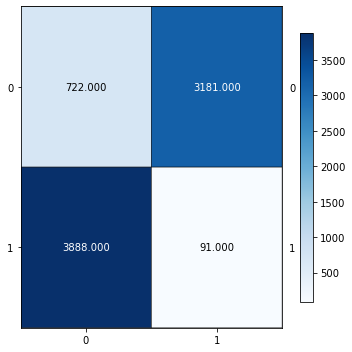

In [69]:
#Q2
#Get labels to verify k means accuracy

from sklearn.cluster import KMeans
from plotmat import plot_mat
from sklearn.metrics.cluster import contingency_matrix

dataset_targets_bin = dataset.target.copy()
for i in range(len(dataset_targets_bin)):
    if dataset.target[i] in [0,1,2,3]:
        dataset_targets_bin[i] = 0
    else:
        dataset_targets_bin[i] = 1

kmeans_clf = KMeans(n_clusters=2, max_iter=1500, random_state=0, n_init=50)
kmeans_clf.fit(X_tfidf)
km_cont_mat = contingency_matrix(dataset_targets_bin, kmeans_clf.labels_)

plot_mat(km_cont_mat, size=(5,5))
        

In [59]:
#Q3
from sklearn import metrics
print("Homogeneity score: ", metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_))
print("Completeness score: ", metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_))
print("V_measure score: ", metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_))
print("Adjusted Mutual Information Score: ", metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_))


Homogeneity score:  0.5600025412974119
Completeness score:  0.5716557539454379
V_measure score:  0.5657691483417876
Adjusted Rand Index score:  0.6327475635535726
Adjusted Mutual Information Score:  0.5657289846874574


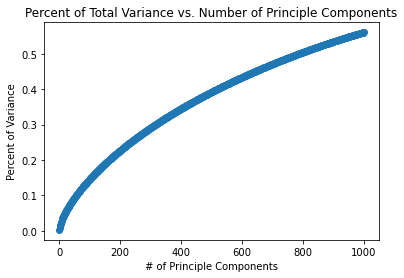

In [72]:
#Q4 
#Random state?

from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np

variances = []
r_vals = np.arange(1, 1001)

trunc_svd = TruncatedSVD(n_components=1000, random_state=0)
X_svd = trunc_svd.fit_transform(X_tfidf)

variances = trunc_svd.explained_variance_ratio_

plt.scatter(r_vals, np.cumsum(variances))
plt.xlabel("# of Principle Components")
plt.ylabel("Percent of Variance")
plt.title("Percent of Total Variance vs. Number of Principle Components")
plt.show()

In [61]:

#Q5
r_vals_5 = [1,2,3,5,10,20,50,100,300]
metric_scores_svd = []
metric_scores_nmf = []

for r in r_vals_5:
    nmf_model = NMF(n_components=r, init='random', random_state=0, max_iter=1000)
    nmf_red = nmf_model.fit_transform(X_tfidf)
    svd_red = X_svd[:,:r]
    
    kmeans_clf.fit(nmf_red)
    metric_scores_nmf.append((metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_)))
    kmeans_clf.fit(svd_red)
    metric_scores_svd.append((metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_)))

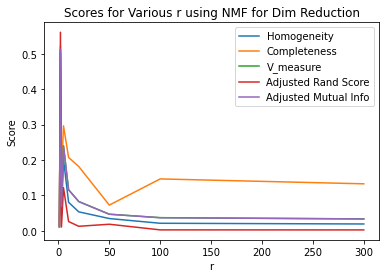

In [62]:
plt.plot(r_vals_5, metric_scores_nmf)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("r")
plt.ylabel("Score")
plt.title("Scores for Various r using NMF for Dim Reduction")
plt.show()

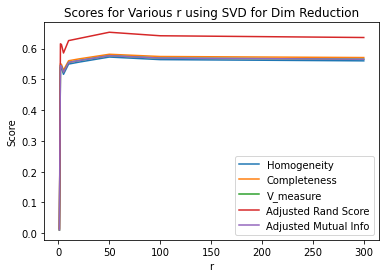

In [64]:
plt.plot(r_vals_5, metric_scores_svd)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("r")
plt.ylabel("Score")
plt.title("Scores for Various r using SVD for Dim Reduction")
plt.show()

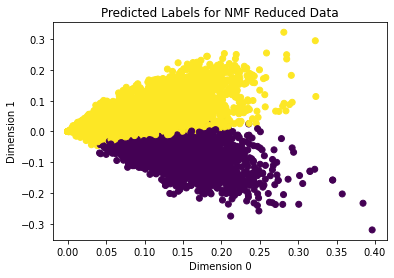

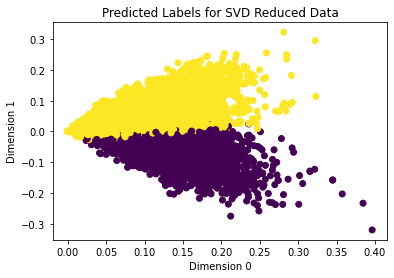

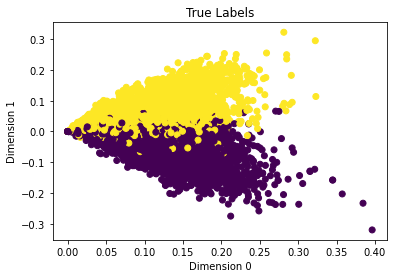

In [74]:
#Q7

nmf_best_k = 2
svd_best_k = 50

reduced_data = X_svd[:,:2]
nmf_model = NMF(n_components=nmf_best_k, init='random', random_state=0, max_iter=1000)
nmf_red = nmf_model.fit_transform(X_tfidf)
kmeans_clf.fit(nmf_red)
nmf_labels = kmeans_clf.labels_

svd_red = X_svd[:,:svd_best_k]
kmeans_clf.fit(svd_red)
svd_labels = kmeans_clf.labels_

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=nmf_labels)
plt.title("Predicted Labels for NMF Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=svd_labels)
plt.title("Predicted Labels for SVD Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=dataset_targets_bin)
plt.title("True Labels")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()



In [ ]:
#Q9